<a href="https://colab.research.google.com/github/Olayile/Research_paper_classifier/blob/master/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

import pandas as pd
import sklearn
import numpy as np
import nltk
import re
import seaborn as sns

nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest


from sklearn.metrics import precision_recall_fscore_support

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olayile/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# from google.colab import files
# uploaded = files.upload()




ModuleNotFoundError: No module named 'google.colab'

In [7]:
import io
# df2 = pd.read_csv(io.BytesIO(uploaded['PoPCites.csv']))
df2= pd.read_csv('/Users/olayile/Research_paper_classifier/PoPCites.csv')

In [8]:
# load data to only get the title and the journal name

def Data(data):
  return data[["Title" ,"Source"]]

def preProcessing(titles):
    stops = set(stopwords.words("english"))
    words = titles.lower().split()
    words = [w.lower() for w in words if not w in stops]
    return words
    
def preProcessing2(features):
    num_titles = features.size
    clean_wordlist = []
    clean_titles = []
    stops = set(stopwords.words('english'))
    for i in range( 0, num_titles):
        #letters_only = re.sub("[^a-zA-Z]", " ", features[i]) 
        words = features[i].lower().split()
        words = [w.lower() for w in words if not w in stops]  
        clean_wordlist.append(words)
        clean_titles.append(" ".join(words))
    return clean_titles, clean_wordlist


In [9]:
Data_new= df2[["Title" ,"Source"]]
Data_new.dropna(inplace=True)
Data_new['Title'].apply(preProcessing)

1      [chapter, 1., introduction, sulfur, chemical, ...
2      [part, ii:, chemical, biology, organosulfur, m...
3       [part, i:, inorganic, sulfur, chemical, biology]
4      [created, green, chemical, engineering, (green...
5           [chapter, 10., n–p, bond, chemical, biology]
                             ...                        
195              [physical, methods, chemical, analysis]
196                        [physics, chemical, industry]
197             [chemical, checkers, chemical, dominoes]
198    ["chemical, age", chemical, dictionary:, chemi...
199    [“chemical, age”, chemical, dictionary:, chemi...
Name: Title, Length: 191, dtype: object

[Text(0, 0, 'The Chemical Biology of Sulfur'),
 Text(0, 0, 'Green Chemical Engineering'),
 Text(0, 0, 'The Chemical Biology of Phosphorus'),
 Text(0, 0, 'Introduction to Chemical Engineering'),
 Text(0, 0, 'Oxford Scholarship Online'),
 Text(0, 0, 'Kinetics of Chemical Reactions'),
 Text(0, 0, 'Chemical Engineering Education'),
 Text(0, 0, 'Chemical Engineering for Non‐Chemical Engineers'),
 Text(0, 0, 'Syria and the Chemical Weapons Taboo'),
 Text(0, 0, 'Journal of Chemical Health and Safety'),
 Text(0, 0, 'Chemical Modelling'),
 Text(0, 0, 'AccessScience'),
 Text(0, 0, 'Chemical Equilibria'),
 Text(0, 0, 'Chemical Reaction Technology'),
 Text(0, 0, 'Chemical Physics Letters'),
 Text(0, 0, 'The Chemical Bond'),
 Text(0, 0, 'Physical and Chemical Equilibrium for Chemical Engineers'),
 Text(0, 0, 'Chemical Reactor Analysis and Applications for the Practicing Engineer'),
 Text(0, 0, 'Introduction to Pharmaceutical Chemical Analysis'),
 Text(0, 0, 'Chemical Thermodynamics at a Glance'),
 

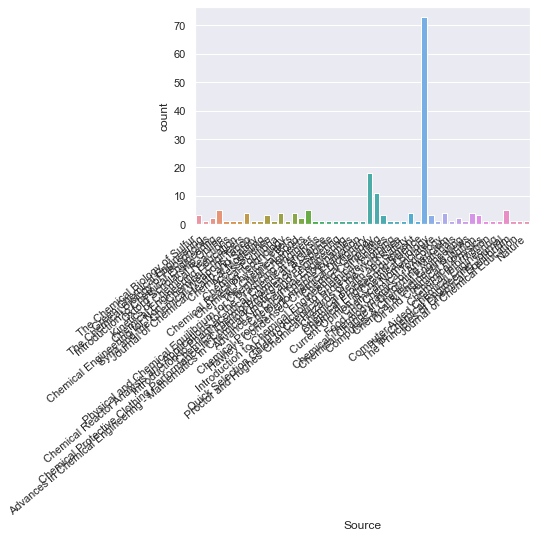

In [11]:
Data_new

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Source", data=Data_new)


ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=4)

In [58]:
# Convert our text to numeric form using erm frequency-inverse document frequency or TF-IDF.

def getDTMByTFIDF(titles,nfeatures):
    tfIdf_vectorizer = TfidfVectorizer(max_features=nfeatures)
    dtm = tfIdf_vectorizer.fit_transform(titles).toarray()
    return dtm, tfIdf_vectorizer

In [59]:
def featuresByChiSq(features,labels,nFeature=5000):
    chi2_model = SelectKBest(chi2,k=nFeature)
    dtm = chi2_model.fit_transform(features,labels)
    return dtm,chi2_model

def featuresByInformationGain(features,labels):
    treeCL = tree.DecisionTreeClassifier(criterion="entropy")
    treeCL = treeCL.fit(features,labels)
    transformed_features = SelectFromModel(treeCL,prefit=True).transform(features)
    return transformed_features

def featuresByLSA(features,ncomponents=100):
    svd = TruncatedSVD(n_components=ncomponents)
    normalizer =  Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    dtm_lsa = lsa.fit_transform(features)
    return dtm_lsa

In [63]:
def makeFeatureVec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word]) 

    feature_vec = np.divide(feature_vec,nwords)
   
    return feature_vec

def getAvgFeatureVecs(title, model, num_features):
    counter = 0.
    titleFeatureVecs = np.zeros((len(title), num_features),dtype="float32")
    for t in title:
        titleFeatureVecs[counter] = makeFeatureVec(t, model,num_features)
        counter = counter + 1.
    return titleFeatureVecs

In [ ]:

def crossValidate(document_term_matrix,labels,classifier="SVM",nfold=2):
    clf = None
    precision = []
    recall = []
    fscore = []
    
    if classifier == "RF":
        clf = RandomForestClassifier()
    elif classifier == "NB":
        clf = MultinomialNB()
    elif classifier == "SVM":
        clf = LinearSVC()
    
    skf = StratifiedKFold(labels, n_folds=nfold)

    for train_index, test_index in skf:
        X_train, X_test = document_term_matrix[train_index], document_term_matrix[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        precision.append(p)
        recall.append(r)
        fscore.append(f)
        
    return np.mean(precision),np.mean(recall),np.mean(fscore)

In [68]:
titles = Data_new['Title']
labels = Data_new['Source']

dtm,vect = getDTMByTFIDF(titles,None)

chisqDtm, chisqModel = featuresByChiSq(dtm,labels,200)

processed_titles, processed_titles_wordlist = preProcessing2(titles)

KeyError: ignored

In [62]:
# We will use three classification algorithms to categorize research papers. 1) Support vector machine with linear kernel 2) Random forest and 3) Multinomial Naïve Bayes.
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 1       # Number of threads to run in parallel
context = 8           # Context window size                                                                                    
downsampling = 1e-5   # Downsample setting for frequent words

word2vec_model = Word2Vec(processed_titles_wordlist, workers=num_workers, 
            size=num_features, min_count = min_word_count, 
            window = context, sample = downsampling)
word2vec_model.init_sims(replace=True)


NameError: ignored